In [2]:
import sys
import os
os.chdir('./..')
sys.path.append(os.getcwd())

In [12]:
from playlist_explanation.run import save_graph_the_chain
from analyze_answers import segue_eval_df, load_answers, user_traits_df, interestingness_df, segue_text_df, familiarity_df, pull_treatment,segue_category_df, user_category_df
import pandas as pd
from scipy import stats
import seaborn as sns
sns.set_theme()
pd.set_option("max_rows", 40)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import logging
logging.getLogger().setLevel(logging.ERROR)

def trunc(number, n_digits):
    return '{:.{prec}f}'.format(number, prec=n_digits)

<a id="top"></a>

# User categories
<a id="user_categories"></a>
[Go to top](#top)

### Separation strategies

#### Mean ± std

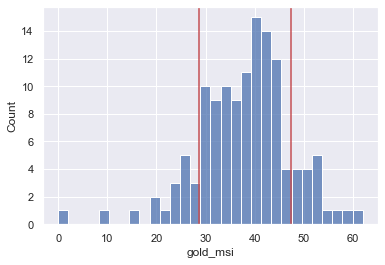

In [3]:
df_traits = user_traits_df(load_answers()).drop("proficiency", axis=1)
df_traits['gold_msi']=df_traits[df_traits.columns[1:]].sum(axis=1)
df_traits=df_traits[df_traits.columns[[0,10]]]
mean=df_traits.gold_msi.mean()
std=df_traits.gold_msi.std()
_=sns.histplot(df_traits['gold_msi'], bins=30)
for n in [mean-std, mean+std]:
    plt.axvline(n, 0,100, color='r')

Categories are of very un-even size!!! I discard this strategy

### Three-twotiles

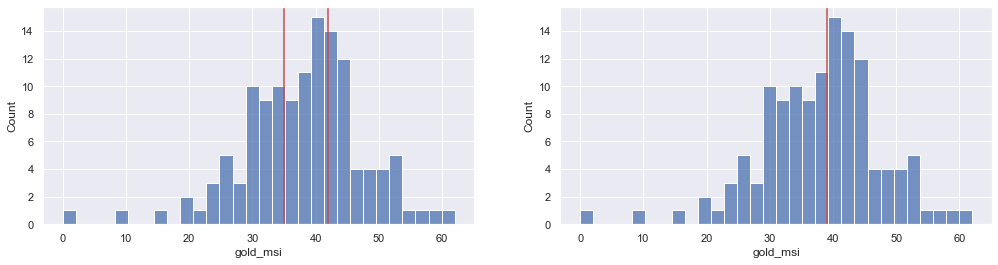

In [4]:
f, ax = plt.subplots(figsize=(17,4), nrows=1, ncols=2)
df_traits = user_traits_df(load_answers()).drop("proficiency", axis=1)
df_traits['gold_msi']=df_traits[df_traits.columns[1:]].sum(axis=1)
df_traits=df_traits[df_traits.columns[[0,10]]]
_=sns.histplot(df_traits['gold_msi'], bins=30, ax=ax[0])
for n in df_traits['gold_msi'].quantile([0.33,0.66]):
    ax[0].axvline(n, 0,100, color='r')
_=sns.histplot(df_traits['gold_msi'], bins=30, ax=ax[1])
for n in df_traits['gold_msi'].quantile([0.5]):
    ax[1].axvline(n, 0,100, color='r')

# Performance
<a id="performance"></a>

## Metrics
<a id="metrics"></a>
[Go to top](#top)

#### Union

In [5]:
def performance_table(df, attribute, test_type='rel', tests=[], include_union=False):
    digits=3
    attribute = attribute if type(attribute) is list else [attribute]
    l=['likeable', 'high_quality', 'understandable','sparked_interest','funny','informative','creative','well_written']
    _df=df[attribute+l]
    add1=_df.groupby(attribute).mean().astype(np.object)
    add2=_df[l].mean().to_frame().T.rename({0:'union'}).astype(np.object)
    
    add1_formatted = add1.copy()
    add2_formatted = add2.copy()
    for v1, v2 in tests:
        for j, c in enumerate(l):

            df_slice_v1=df.copy()
            for a,v in zip(attribute,[v1] if type(v1) is not list else v1):
                df_slice_v1 = df_slice_v1[df_slice_v1[a]==v]
                
            df_slice_v2=df.copy()
            for a,v in zip(attribute,[v2] if type(v2) is not list else v2):
                df_slice_v2 = df_slice_v2[df_slice_v2[a]==v]
            
            if test_type=='rel':
                statistics, p = stats.ttest_rel(df_slice_v1[c].values, df_slice_v2[c].values, nan_policy='omit')
            elif test_type=='ind':
                statistics, p = stats.ttest_ind(df_slice_v1[c].values, df_slice_v2[c].values, nan_policy='omit')

            if p < 0.001:
                score_prefix = '***'
            elif p >= 0.001 and p<0.01:
                score_prefix = '**'
            elif p>=0.01 and p<0.05:
                score_prefix = '*'
            else:
                score_prefix = ''
                
            if add1.loc[v1][j]>=add1.loc[v2][j]:
                add1_formatted.loc[v1][j] = f"{trunc(add1.loc[v1][j],digits)}{score_prefix}"
                add1_formatted.loc[v2][j] = trunc(add1.loc[v2][j],digits)
            else:
                add1_formatted.loc[v1][j] = trunc(add1.loc[v1][j],digits)
                add1_formatted.loc[v2][j] = f"{trunc(add1.loc[v2][j],digits)}{score_prefix}"

            add2_formatted.iloc[0][j] = trunc(add2.iloc[0][j],digits)
    
    if include_union:
        return pd.concat([add1_formatted[l], add2_formatted[l]])
    else:
        return add1_formatted[l]

In [6]:
def step(df):
    l=['likeable', 'high_quality', 'understandable','sparked_interest','funny','informative','creative','well_written']
    _df=df[['treatment']+l]
    add1=_df.groupby('treatment').mean().astype(np.object)
    add2=_df[l].mean().to_frame().T.rename({0:'union'}).astype(np.object)
    return pd.concat([add1, add2])

def add_bootstrap_ci(df, f):
    result_template = f(df).astype(np.object)
    bootstrap_replicas = [df.sample(n=len(df), replace=True) for _ in range(1000)]
    results = [step(r).to_numpy() for r in bootstrap_replicas]
    mean=np.mean(results, axis=0)
    interval=np.percentile(results, 97.5, axis=0)-np.percentile(results, 2.5, axis=0)
    for i in range(mean.shape[0]):
        for j in range(mean.shape[1]):
            result_template.iloc[i][j] = f"{trunc(mean[i][j],2)}±{trunc(interval[i][j],2)}"
    return result_template

#### Partition by user category

In [7]:
print("First quartile")
df_eval = segue_eval_df(load_answers())
df_user_cat = user_category_df()
df = df_eval.set_index('user_idx').join(df_user_cat.set_index('user_idx'), how='left').reset_index()
performance_table(df[df.user_category == '1'], attribute='treatment', tests=[('dave', 'the_chain')])

First quartile


,likeable,high_quality,understandable,sparked_interest,funny,informative,creative,well_written
treatment,,,,,,,,
dave,2.989,2.889,3.644,2.489,2.322,3.267,3.133,3.278
the_chain,3.144,3.078,3.767,2.744,2.800***,2.978,3.511**,3.133


In [8]:
print("Second quartile")
performance_table(df[df.user_category == '2'], attribute='treatment', tests=[('dave', 'the_chain')])

Second quartile


,likeable,high_quality,understandable,sparked_interest,funny,informative,creative,well_written
treatment,,,,,,,,
dave,3.069,3.011,3.628,2.862,2.529,3.138,3.349,3.176
the_chain,3.395*,3.209,3.744,3.024,2.837*,2.965,3.435,3.282


In [9]:
print("Third quartile")
performance_table(df[df.user_category == '3'], attribute='treatment', tests=[('dave', 'the_chain')])

Third quartile


,likeable,high_quality,understandable,sparked_interest,funny,informative,creative,well_written
treatment,,,,,,,,
dave,3.219,3.048,3.848,3.133,2.619,3.314,3.286,3.390
the_chain,3.238,3.086,3.644,3.181,2.876*,3.124,3.657***,3.476


In [10]:
print("Fourth quartile")
performance_table(df[df.user_category == '4'], attribute='treatment', tests=[('dave', 'the_chain')])

Fourth quartile


,likeable,high_quality,understandable,sparked_interest,funny,informative,creative,well_written
treatment,,,,,,,,
dave,3.162,3.051,3.806,3.020,2.485,3.253,3.398,3.320
the_chain,3.343,3.255,3.929,3.061,2.755*,3.040,3.626*,3.381


- *Did also threetile and twotile, but we observe same behaviour than in quartiles.*
- No significant differences between Dave and The Chain separately, wrt to how they behaved separately in the union.

#### Partition by segue category and user category

In [11]:
print("Informative segues, 1 Quartile")
df_eval = segue_eval_df(load_answers())
df_segue_cat = segue_category_df()
df_user_cat = user_category_df(separation='fourway')
df = df_eval.set_index('user_idx').join(df_user_cat.set_index('user_idx'), how='left').reset_index()
df = df.set_index(['segue_idx','treatment']).join(df_segue_cat.set_index(['segue_idx','treatment']), how='left').reset_index()
performance_table(df[(df.user_category == '1') & (df.segue_category == 'I')], attribute='treatment', tests=[('dave', 'the_chain')],test_type='ind')

Informative segues, 1 Quartile


,likeable,high_quality,understandable,sparked_interest,funny,informative,creative,well_written
treatment,,,,,,,,
dave,3.292,3.292,3.938,2.792,2.250,3.938**,3.292,3.479*
the_chain,2.885,3.000,3.769,2.808,2.500,3.346,3.500,2.846


In [12]:
print("Informative segues, 2 Quartile")
performance_table(df[(df.user_category == '2') & (df.segue_category == 'I')], attribute='treatment', tests=[('dave', 'the_chain')], test_type='ind')

Informative segues, 2 Quartile


,likeable,high_quality,understandable,sparked_interest,funny,informative,creative,well_written
treatment,,,,,,,,
dave,3.413,3.348,3.933,3.239,2.457,3.761,3.565,3.533
the_chain,3.471,3.353,3.647,3.471,2.588,3.529,3.471,3.353


In [13]:
print("Informative segues, 3 Quartile")
performance_table(df[(df.user_category == '3') & (df.segue_category == 'I')], attribute='treatment', tests=[('dave', 'the_chain')], test_type='ind')

Informative segues, 3 Quartile


,likeable,high_quality,understandable,sparked_interest,funny,informative,creative,well_written
treatment,,,,,,,,
dave,3.237,3.153,3.881,3.153,2.424,3.729,3.271,3.508
the_chain,3.240,3.120,3.640,3.320,2.880*,3.720,3.600,3.560


In [14]:
print("Informative segues, 4 Quartile")
performance_table(df[(df.user_category == '4') & (df.segue_category == 'I')], attribute='treatment', tests=[('dave', 'the_chain')], test_type='ind')

Informative segues, 4 Quartile


,likeable,high_quality,understandable,sparked_interest,funny,informative,creative,well_written
treatment,,,,,,,,
dave,3.220,3.204,3.816,3.160,2.320,3.840,3.380,3.360
the_chain,3.522,3.455,3.957,3.217,2.522,3.609,3.696,3.478


- No statistical significant differences between treatments, in none of the 4 tables where informative is involved.

In [19]:
df_eval = segue_eval_df(load_answers())
df_segue_cat = segue_category_df()
df_user_cat = user_category_df(separation='fourway')
df = df_eval.set_index('user_idx').join(df_user_cat.set_index('user_idx'), how='left').reset_index()
df = df.set_index(['segue_idx','treatment']).join(df_segue_cat.set_index(['segue_idx','treatment']), how='left').reset_index()
print("Funny segues, 1 Quartile")
performance_table(df[(df.user_category == '1') & (df.segue_category == 'F')], attribute='treatment', tests=[('dave', 'the_chain')], test_type='ind')

Funny segues, 1 Quartile


,likeable,high_quality,sparked_interest,funny,informative,creative,understandable,well_written
dave,2.66,2.45,2.16,2.43,2.50,2.98,3.30,3.05
the_chain,3.29**,3.14**,2.75**,2.90*,2.81,3.47*,3.71,3.23


In [20]:
print("Funny segues, 2 Quartile")
performance_table(df[(df.user_category == '2') & (df.segue_category == 'F')], attribute='treatment', tests=[('dave', 'the_chain')], test_type='ind')

Funny segues, 2 Quartile


,likeable,high_quality,sparked_interest,funny,informative,creative,understandable,well_written
dave,2.84,2.76,2.62,2.67,2.47,3.07,3.45,2.89
the_chain,3.26*,3.09,2.90,2.92,2.75,3.41,3.73,3.20*


In [21]:
print("Funny segues, 3 Quartile")
performance_table(df[(df.user_category == '3') & (df.segue_category == 'F')], attribute='treatment', tests=[('dave', 'the_chain')], test_type='ind')

Funny segues, 3 Quartile


,likeable,high_quality,sparked_interest,funny,informative,creative,understandable,well_written
dave,3.08,2.86,3.20,2.94,2.82,3.35,3.76,3.22
the_chain,3.28,3.16,3.20,2.87,3.07,3.74**,3.69,3.54*


In [22]:
print("Funny segues, 4 Quartile")
performance_table(df[(df.user_category == '4') & (df.segue_category == 'F')], attribute='treatment', tests=[('dave', 'the_chain')], test_type='ind')

Funny segues, 4 Quartile


,likeable,high_quality,sparked_interest,funny,informative,creative,understandable,well_written
dave,3.13,2.93,2.95,2.75,2.82,3.42,3.75,3.32
the_chain,3.28,3.18,3.09,2.87,2.97,3.66,3.97,3.42


- Funny segues from dave are appreciated much more with quartiles, and the difference stops being statistical significant

Done the same table also with twotiles and threetiles but nothing interesting stands out.

Across treatments

In [15]:
print("Informataive segues")
performance_table(df[df.segue_category == 'I'], attribute='user_category', tests=[('1','2'),('1','3'), ('1','4')], test_type='ind')

Informataive segues


,likeable,high_quality,understandable,sparked_interest,funny,informative,creative,well_written
user_category,,,,,,,,
1,3.149,3.189,3.878,2.797,2.338,3.730,3.365,3.257
2,3.429,3.349,3.855,3.302**,2.492,3.698,3.540,3.484
3,3.238,3.143,3.810,3.202*,2.560,3.726,3.369,3.524
4,3.315,3.282,3.861,3.178*,2.384,3.767,3.479,3.397


In [16]:
print("Funny segues")
performance_table(df[df.segue_category == 'F'], attribute='user_category', tests=[('1','2'),('1','3'), ('1','4')], test_type='ind')

Funny segues


,likeable,high_quality,understandable,sparked_interest,funny,informative,creative,well_written
user_category,,,,,,,,
1,3.009,2.840,3.585,2.491,2.717,2.698,3.292,3.170
2,3.118,2.973,3.591,2.734,2.791,2.682,3.306,3.083
3,3.222,3.016,3.704,3.127***,2.873,2.881,3.540,3.373
4,3.216,3.080,3.871,2.960**,2.758,2.784,3.532,3.322


Testing first row against all the other

- Funny segues appreciated not much differently when going from pop to nerds;
- Informative segues appreciated not much differently when going from pop to nerds;

Done the same thing with twotiles and threetiles, but we always observe uniform appreciation when going up with tiles.

## Heatmaps
<a id="heatmaps"></a>
[Go to top](#top)

#### Union

In [17]:
digits=2
def heatmap_pvalues(df,rows=['likeable', 'high_quality', 'sparked_interest', 'understandable'], headers=['interestingness', 'unpopularity', 'rarity', 'shortness']):
    l_ticks=['l', 'h_q', 'u', 's_i', 'f', 'i', 'c', 'w_w']
    vals = []
    signs = []
    df_l=[]
    for r in rows:
        val = []
        sign = []
        d={}
        for h in headers:
            if r==h:
                val.append(1)
                sign.append('1')
            else:
                # person r do not accept nans, and require arrays to be all of the same size
                copy=df[[r,h]]
                copy=copy.dropna()
                s, p = stats.spearmanr(copy[r].values, copy[h].values,)
                val.append(s)
                if p<0.001:
                    sign.append(f"{trunc(s,digits)}***")
                elif p>=0.001 and p<0.01:
                    sign.append(f"{trunc(s,digits)}**")
                elif p>=0.01 and p<0.05:
                    sign.append(f"{trunc(s,digits)}*")
                else:
                    sign.append(trunc(s,digits))
        vals.append(val)
        signs.append(sign)
    
    f, ax = plt.subplots(figsize=(13,4), nrows=1, ncols=1)
    sns.heatmap(np.array(vals), vmin=-1, vmax=1, annot=np.array(signs), cmap='BrBG', fmt='', annot_kws={'size':15}, xticklabels=l_ticks, yticklabels=l_ticks, ax=ax)

In [18]:
def heatmap(df, between_treatments=True):
    bootstrap_df = [df.sample(n=len(df), replace=True) for _ in range(1000)]
    l=['likeable', 'high_quality', 'understandable', 'sparked_interest', 'funny', 'informative', 'creative', 'well_written']
    l_ticks=['l', 'h_q', 'u', 's_i', 'f', 'i', 'c', 'w_w']
    sns.set_context("talk",font_scale=1)

    if between_treatments:
        f, ax = plt.subplots(figsize=(17,4), nrows=1, ncols=2)
        for k, w in enumerate(['dave', 'the_chain']):
            ax[k].set_title(w)
            bootstrap_heatmaps=[r[(r['treatment']==w)][l].corr(method='pearson').to_numpy() for r in bootstrap_df]
            mean=np.mean(bootstrap_heatmaps, axis=0)
            interval=np.percentile(bootstrap_heatmaps, 97.5, axis=0)-np.percentile(bootstrap_heatmaps, 2.5, axis=0)
            annotation=np.empty((8,8), dtype=np.object)
            for i in range(8):
                for j in range(8):
                    if i==j:
                        annotation[i][j]="1.00"
                    else:
                        annotation[i][j]=f"{trunc(mean[i][j],2)}±{trunc(interval[i][j],2)}"
            _=sns.heatmap(mean, vmin=-1, vmax=1, annot=annotation, cmap='BrBG', fmt='', annot_kws={'size':11}, xticklabels=l_ticks, yticklabels=l_ticks if k==0 else ['' for _ in range(8)] , ax=ax[k], cbar=False)

    f, ax = plt.subplots(figsize=(17,4), nrows=1, ncols=1)
    ax.set_title('union')
    bootstrap_heatmaps=[r[l].corr(method='pearson').to_numpy() for r in bootstrap_df]
    mean=np.mean(bootstrap_heatmaps, axis=0)
    interval=np.percentile(bootstrap_heatmaps, 97.5, axis=0)-np.percentile(bootstrap_heatmaps, 2.5, axis=0)
    annotation=np.empty((8,8), dtype=np.object)
    for i in range(8):
        for j in range(8):
            if i==j:
                annotation[i][j]="1.00"
            else:
                annotation[i][j]=f"{trunc(mean[i][j],2)}±{trunc(interval[i][j],2)}"
    _=sns.heatmap(mean, vmin=-1, vmax=1, annot=annotation, cmap='BrBG', fmt='', annot_kws={'size':15}, xticklabels=l_ticks, yticklabels=l_ticks, ax=ax)


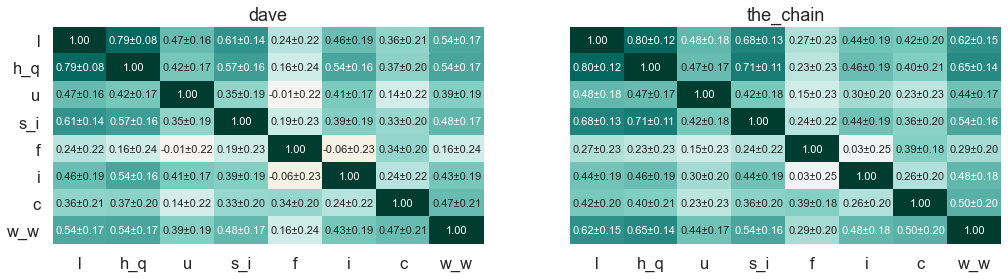

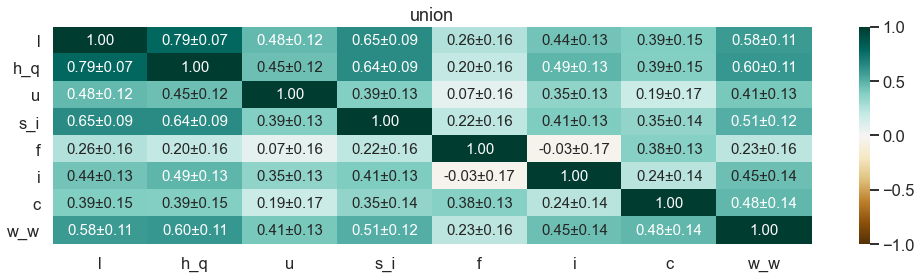

In [19]:
heatmap(segue_eval_df(load_answers()))

Comments between treatments:
- Feels like telling the same story. The only difference (probabily _not_ stat. significant) is on the correlation between h_q and s_i.

CIs confirms that those two heatmaps actually tell the same story!! show just the union.

#### Partition by user category

First quartile


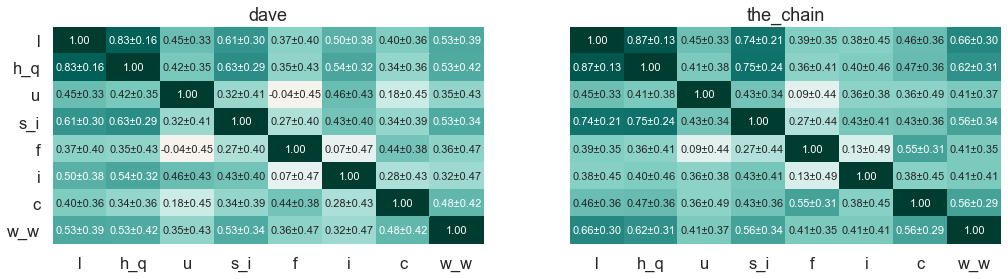

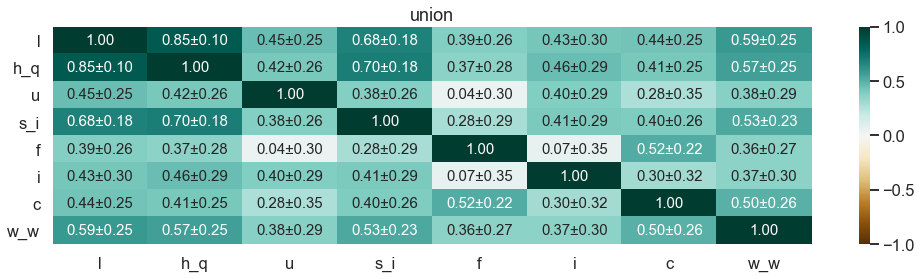

In [20]:
print("First quartile")
eval_df=segue_eval_df(load_answers())
user_cat_df=user_category_df()
df=eval_df.set_index('user_idx').join(user_cat_df.set_index('user_idx'), how='left').reset_index()
heatmap(df[df.user_category=='1'])

- No diff between treatments
- No diff with the overall union

Second quartile


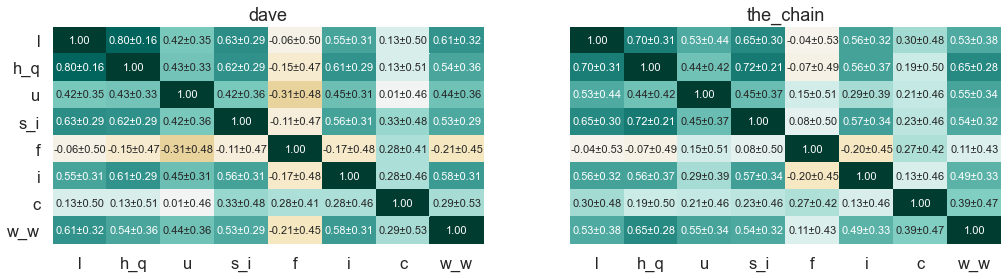

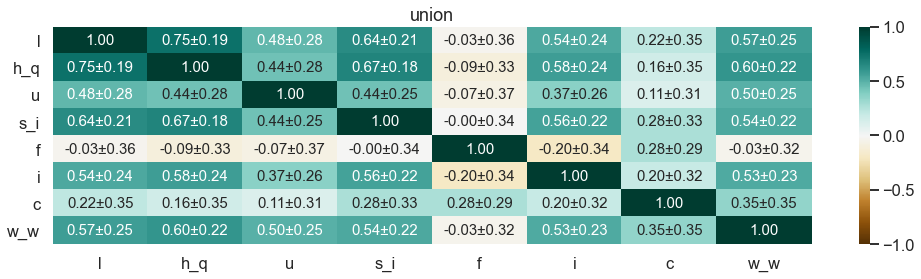

In [21]:
print("Second quartile")
eval_df=segue_eval_df(load_answers())
user_cat_df=user_category_df()
df=eval_df.set_index('user_idx').join(user_cat_df.set_index('user_idx'), how='left').reset_index()
heatmap(df[df.user_category=='2'])

- Lots of uncertainty

Third quartile


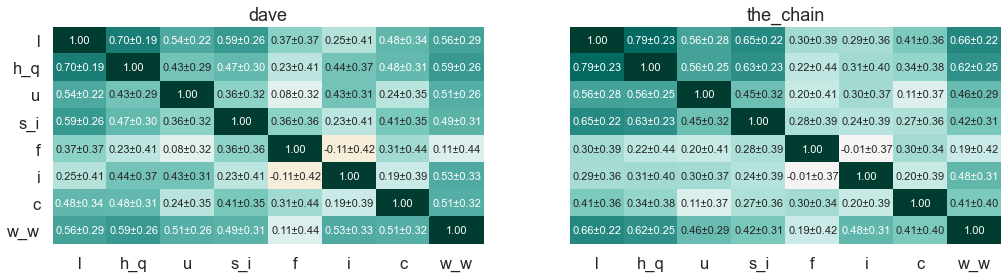

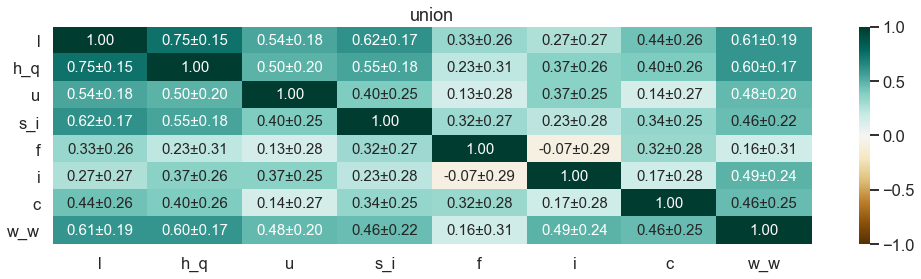

In [22]:
print("Third quartile")
eval_df=segue_eval_df(load_answers())
user_cat_df=user_category_df()
df=eval_df.set_index('user_idx').join(user_cat_df.set_index('user_idx'), how='left').reset_index()
heatmap(df[df.user_category=='3'])

- Too much uncertainty!!

Fourth quartile


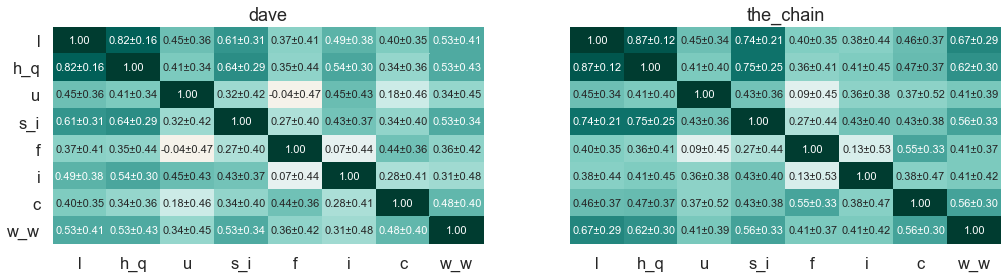

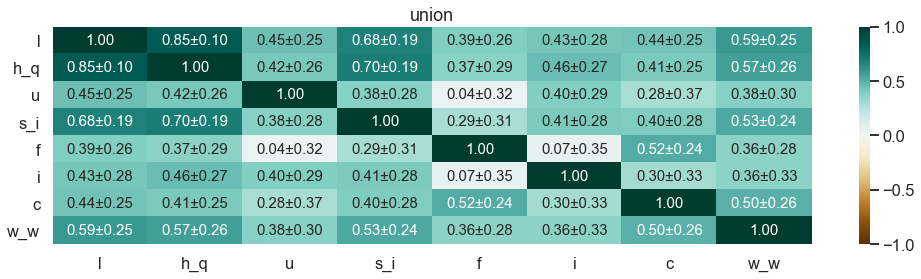

In [23]:
print("Fourth quartile")
eval_df=segue_eval_df(load_answers())
user_cat_df=user_category_df()
df=eval_df.set_index('user_idx').join(user_cat_df.set_index('user_idx'), how='left').reset_index()
heatmap(df[df.user_category=='1'])

- No diff between treatments
- No diff with the overall union

#### Partition segue category

Informative


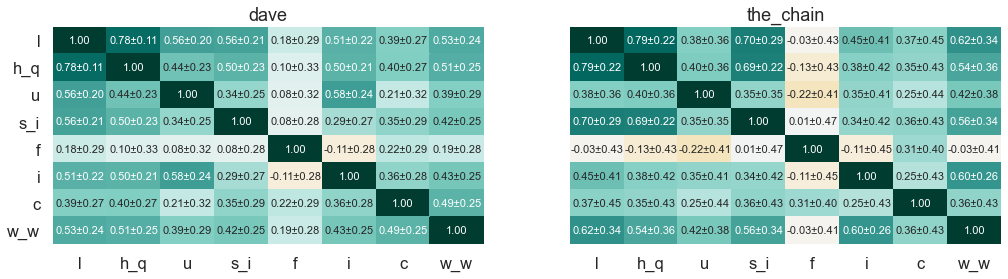

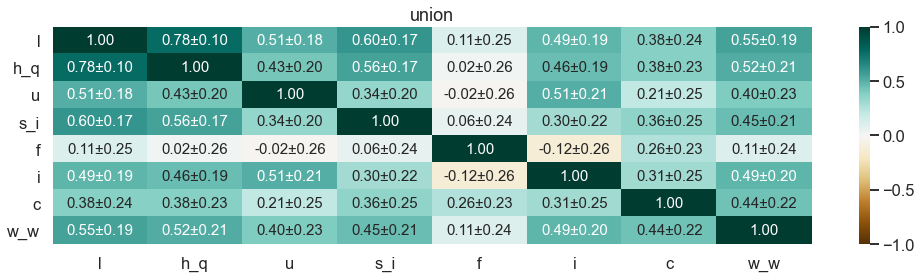

In [24]:
print("Informative")
eval_df=segue_eval_df(load_answers())
segue_cat_df=segue_category_df()
df=eval_df.set_index(['segue_idx','treatment']).join(segue_cat_df.set_index(['segue_idx','treatment']), how='left').reset_index()
heatmap(df[df.segue_category=='I'])

- No diff between treatments
- No diff of this union with overall union, if we exclude funny. Funny and quality metrics here are almost uncorrelated

Funny


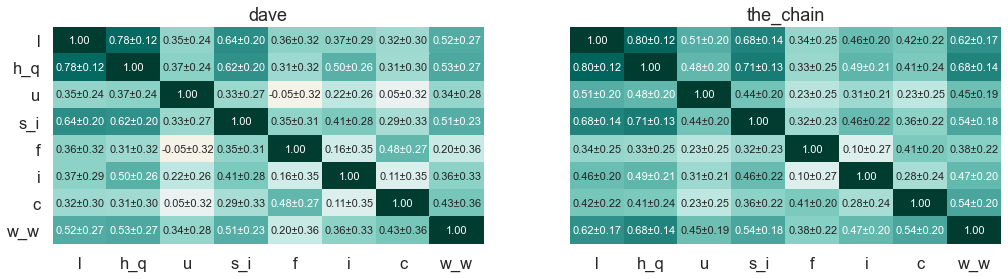

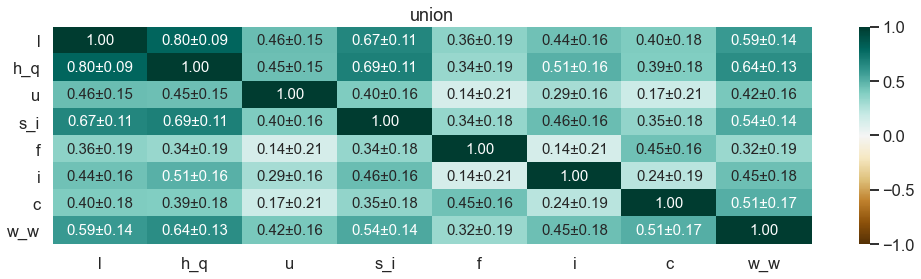

In [25]:
print('Funny')
heatmap(df[df.segue_category=='F'])

- No diff between treatments
- No diff of this union with overall union

# Interestingness and metrics
<a id="interestingness"></a>
[Go to top](#top)

In [4]:
int_df=interestingness_df(load_answers())
eval_df = segue_eval_df(load_answers())
eval_df=eval_df[eval_df.treatment=='dave'].reset_index(drop=True)
segue_cat_df=segue_category_df()
user_cat_df = user_category_df()
segue_cat_df=segue_cat_df[segue_cat_df.treatment=='dave'].drop(['treatment'],axis=1)
df = eval_df.set_index('segue_idx').join(int_df.set_index('segue_idx'), how="left").join(segue_cat_df.set_index('segue_idx'), how='left').reset_index()
df = df.set_index('user_idx').join(user_cat_df.set_index('user_idx'), how='left').reset_index()

The following tables show correlations (r), and statistical test with hyp. being r=0.

#### Union

In [5]:
digits = 3

def correlation_df_CIs(df,rows=['likeable', 'high_quality','sparked_interest','funny','informative','creative', 'understandable','well_written'], headers=['interestingness', 'unpopularity', 'rarity', 'shortness']):
    bootstrap_replicas = [df.sample(n=len(df), replace=True) for _ in range(1000)]
    df_l=[]
    for r in rows:
        d={}
        for h in headers:
            d[h]=[br[r].corr(br[h], method='spearman') for br in bootstrap_replicas]
            interval=np.percentile(d[h], 97.5)-np.percentile(d[h], 2.5)
            d[h]=[f"{trunc(np.mean(d[h]),digits)}±{trunc(interval/2,digits)}"]
        df_l.append(pd.DataFrame(d))
    return pd.concat(df_l).rename({j: k for j,k in enumerate(rows)})

def correlation_df_pvalues(df,rows=['likeable', 'high_quality','sparked_interest','funny','informative','creative', 'understandable','well_written'], headers=['interestingness', 'unpopularity', 'rarity', 'shortness']):
    df_l=[]
    for r in rows:
        d={}
        for h in headers:
            # person r do not accept nans, and require arrays to be all of the same size
            copy=df[[r,h]]
            copy=copy.dropna()
            s, p = stats.spearmanr(copy[r].values, copy[h].values,)
            if p<0.001:
                d[h]=[f"{trunc(s, digits)}***"]
            elif p>=0.001 and p<0.01:
                d[h]=[f"{trunc(s, digits)}**"]
            elif p>=0.01 and p<0.05:
                d[h]=[f"{trunc(s, digits)}*"]
            else:
                d[h]=[trunc(s, digits)]
        df_l.append(pd.DataFrame(d))
    return pd.concat(df_l).reset_index(drop=True).rename({j: k for j,k in enumerate(rows)})

In [6]:
correlation_df_pvalues(df).sort_index()

,interestingness,unpopularity,rarity,shortness
creative,-0.004,0.126**,0.159***,-0.146**
funny,-0.007,0.039,-0.038,0.005
high_quality,0.015,0.067,0.136**,-0.102*
informative,-0.233***,0.124**,0.238***,-0.354***
likeable,0.083,0.041,0.117*,-0.028
sparked_interest,-0.015,0.079,0.098*,-0.082
understandable,0.067,0.061,0.028,-0.009
well_written,-0.048,0.109*,0.127**,-0.174***


\*: p-value < 0.05 </br>
\*\*: p-value < 0.01 </br>
\*\*\*: p-value < 0.001

#### Partition by segue category

In [8]:
o = pd.concat([correlation_df_pvalues(df[df.segue_category=='I']), correlation_df_pvalues(df[df.segue_category=='F'])])
o['segue_category']=['informative']*8+['funny']*8
o=o.set_index('segue_category', append=True, )
o.sort_index()

interestingness unpopularity    rarity  \
                 segue_category                                          
creative         funny                   -0.091       0.172*   0.222**   
                 informative             0.153*        0.065     0.044   
funny            funny                  -0.168*        0.093    0.146*   
                 informative             -0.057        0.070    -0.116   
high_quality     funny                    0.110        0.013   -0.158*   
                 informative           0.232***       -0.006    0.166*   
informative      funny                    0.042       -0.125   -0.163*   
                 informative             0.138*        0.033     0.080   
likeable         funny                    0.130        0.018   -0.145*   
                 informative           0.251***       -0.019   0.179**   
sparked_interest funny                   -0.005        0.010    -0.020   
                 informative            0.166**        0.053     0.072   
understandable   funny                    0.102       -0.051  -0.185**   
                 informative           0.217***        0.101     0.084   
well_written     funny                    0.053        0.082     0.001   
                 informative              0.110        0.037     0.041   

                                shortness  
                 segue_category            
creative         funny           -0.216**  
                 informative       -0.116  
funny            funny           -0.222**  
                 informative       -0.121  
high_quality     funny              0.131  
                 informative        0.101  
informative      funny             0.146*  
                 informative        0.005  
likeable         funny             0.142*  
                 informative       0.156*  
sparked_interest funny             -0.006  
                 informative        0.102  
understandable   funny             0.164*  
                 informative        0.094  
well_written     funny             -0.019  
                 informative       -0.085

- Good results in first column. Bad results in the others;
- Good results in informative segues, bad results in funny segues

#### Analysis by user category

In [9]:
int_df=interestingness_df(load_answers())
eval_df = segue_eval_df(load_answers())
eval_df=eval_df[eval_df.treatment=='dave'].reset_index(drop=True)
segue_cat_df=segue_category_df()
user_cat_df = user_category_df()
segue_cat_df=segue_cat_df[segue_cat_df.treatment=='dave'].drop(['treatment'],axis=1)
df = eval_df.set_index('segue_idx').join(int_df.set_index('segue_idx'), how="left").join(segue_cat_df.set_index('segue_idx'), how='left').reset_index()
df = df.set_index('user_idx').join(user_cat_df.set_index('user_idx'), how='left').reset_index()

In [13]:
o = pd.concat([correlation_df_pvalues(df[df.user_category=='1']), correlation_df_pvalues(df[df.user_category=='2']), correlation_df_pvalues(df[df.user_category=='3']), correlation_df_pvalues(df[df.user_category=='4'])])
o['user_category']=['quartile 1']*8+['quartile 2']*8+['quartile 3']*8+['quartile 4']*8
o=o.set_index('user_category', append=True, )
o.sort_index()

interestingness unpopularity    rarity  \
                 user_category                                          
creative         quartile 1              0.004        0.134     0.175   
                 quartile 2            -0.194*       0.213*  0.303***   
                 quartile 3             0.209*        0.128     0.127   
                 quartile 4             -0.011        0.046     0.090   
funny            quartile 1             -0.031       -0.029     0.090   
                 quartile 2             -0.117        0.052     0.113   
                 quartile 3              0.091        0.135    -0.174   
                 quartile 4              0.029       -0.009    -0.134   
high_quality     quartile 1             -0.151        0.061    0.222*   
                 quartile 2              0.028        0.083     0.162   
                 quartile 3             -0.008        0.123    -0.017   
                 quartile 4              0.142        0.019     0.171   
informative      quartile 1          -0.325***        0.113     0.168   
                 quartile 2             -0.161       0.182*  0.371***   
                 quartile 3           -0.299**        0.144     0.156   
                 quartile 4             -0.167        0.068   0.255**   
likeable         quartile 1             -0.068        0.001     0.166   
                 quartile 2              0.040        0.062     0.164   
                 quartile 3              0.095        0.047     0.027   
                 quartile 4             0.227*        0.055     0.124   
sparked_interest quartile 1            -0.238*        0.019    0.197*   
                 quartile 2             -0.075       0.213*     0.122   
                 quartile 3              0.099       -0.049     0.026   
                 quartile 4              0.093        0.103     0.076   
understandable   quartile 1             -0.079        0.059     0.016   
                 quartile 2              0.022        0.090     0.091   
                 quartile 3              0.078        0.151    -0.023   
                 quartile 4             0.197*       -0.021     0.030   
well_written     quartile 1             -0.054        0.054     0.130   
                 quartile 2             -0.110       0.227*   0.246**   
                 quartile 3             -0.010        0.097     0.036   
                 quartile 4             -0.024        0.089     0.153   

                                shortness  
                 user_category             
creative         quartile 1        -0.160  
                 quartile 2     -0.313***  
                 quartile 3        -0.021  
                 quartile 4        -0.089  
funny            quartile 1        -0.045  
                 quartile 2        -0.115  
                 quartile 3         0.098  
                 quartile 4         0.075  
high_quality     quartile 1       -0.236*  
                 quartile 2        -0.094  
                 quartile 3        -0.075  
                 quartile 4        -0.031  
informative      quartile 1     -0.430***  
                 quartile 2     -0.346***  
                 quartile 3     -0.354***  
                 quartile 4     -0.298***  
likeable         quartile 1        -0.141  
                 quartile 2        -0.084  
                 quartile 3         0.053  
                 quartile 4         0.035  
sparked_interest quartile 1       -0.240*  
                 quartile 2       -0.184*  
                 quartile 3         0.094  
                 quartile 4        -0.039  
understandable   quartile 1        -0.081  
                 quartile 2        -0.096  
                 quartile 3         0.012  
                 quartile 4         0.087  
well_written     quartile 1        -0.176  
                 quartile 2     -0.308***  
                 quartile 3        -0.092  
                 quartile 4        -0.151

- First column goes up with quartiles almost systematically. Interestingness seems to get good segues mostly for nerds;
- No nice trends in the other 3 columns;
- Smaller size of partition, not many statistical significant results.

**Drop this, not statistical significant results (nothing even at 0.05)**

The following tables show correlations (r), and statistical test with hyp. being r=0.

### Showing the same results in a graphical way

#### Union

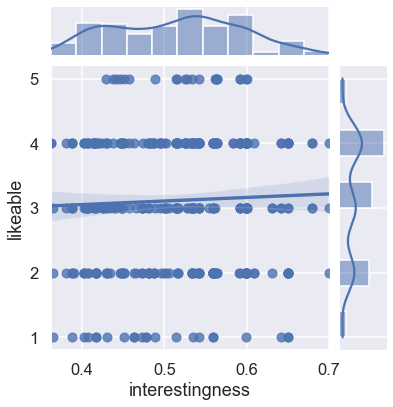

In [31]:
_=sns.jointplot(x="interestingness", y="likeable", data=df, kind="reg")

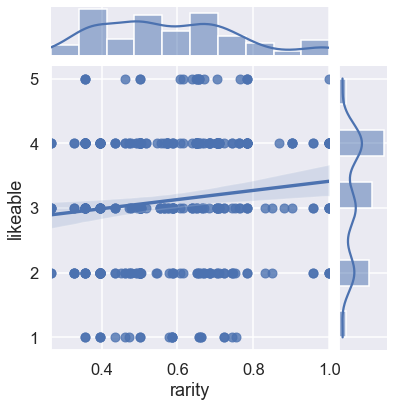

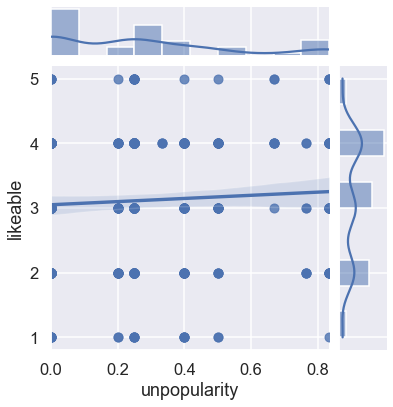

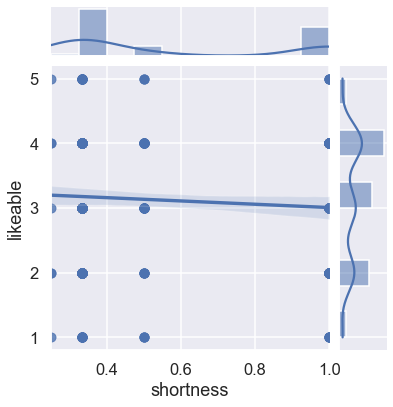

In [32]:
_=sns.jointplot(x="rarity", y="likeable", data=df, kind="reg")
_=sns.jointplot(x="unpopularity", y="likeable", data=df, kind="reg")
_=sns.jointplot(x="shortness", y="likeable", data=df, kind="reg")

#### Partition by segue category

informative segues


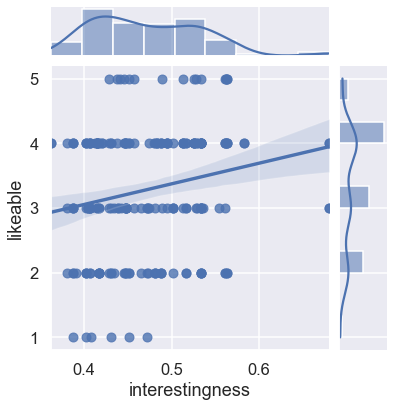

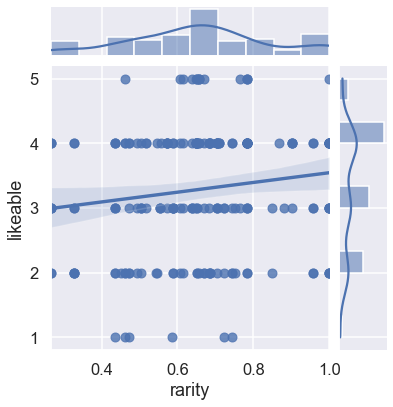

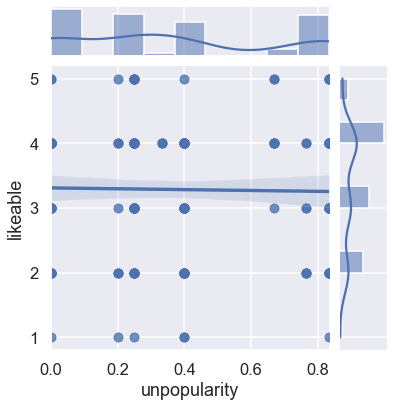

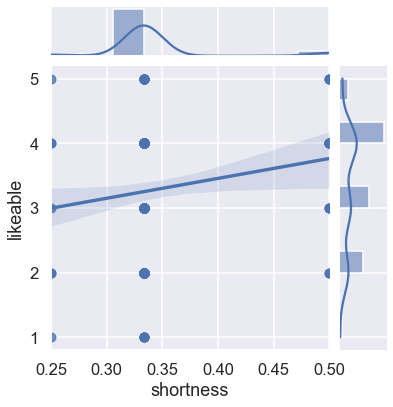

In [33]:
print("informative segues")
_=sns.jointplot(x="interestingness", y="likeable", data=df[df.segue_category=='I'], kind="reg")
_=sns.jointplot(x="rarity", y="likeable", data=df[df.segue_category=='I'], kind="reg")
_=sns.jointplot(x="unpopularity", y="likeable", data=df[df.segue_category=='I'], kind="reg")
_=sns.jointplot(x="shortness", y="likeable", data=df[df.segue_category=='I'], kind="reg")

funny segues


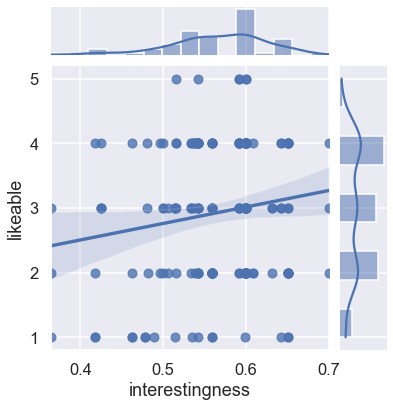

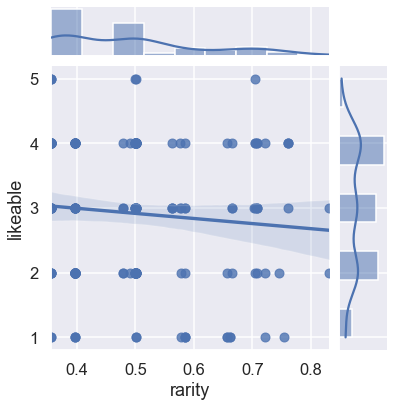

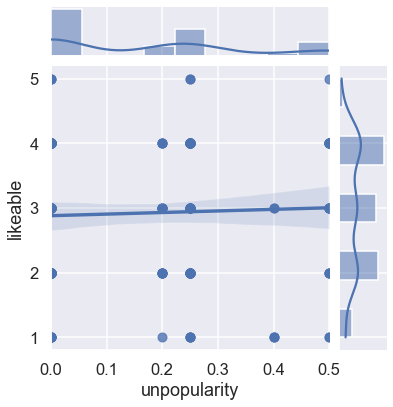

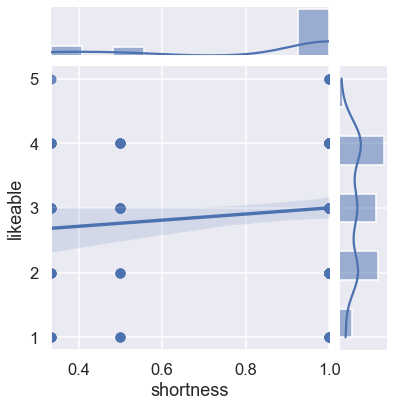

In [34]:
print("funny segues")
_=sns.jointplot(x="interestingness", y="likeable", data=df[df.segue_category=='F'], kind="reg")
_=sns.jointplot(x="rarity", y="likeable", data=df[df.segue_category=='F'], kind="reg")
_=sns.jointplot(x="unpopularity", y="likeable", data=df[df.segue_category=='F'], kind="reg")
_=sns.jointplot(x="shortness", y="likeable", data=df[df.segue_category=='F'], kind="reg")

# Text length and likeability
<a id="text_length"></a>
[Go to top](#top)

#### Union

dave


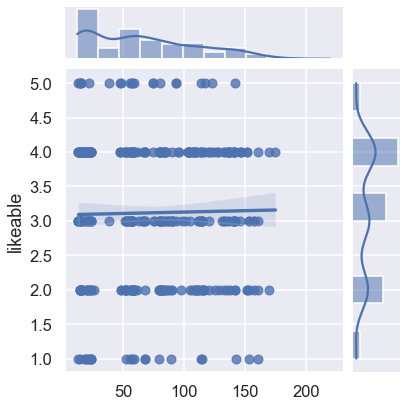

In [35]:
print("dave")
text_df=segue_text_df()
eval_df=segue_eval_df(load_answers())
eval_df=eval_df[eval_df.treatment=='dave']
df=text_df.set_index(['segue_idx','treatment']).join(eval_df.set_index(['segue_idx','treatment'])).reset_index()
_=sns.jointplot(x=[len(e) for e in df['text'].values], y=df['likeable'],kind="reg")

the_chain


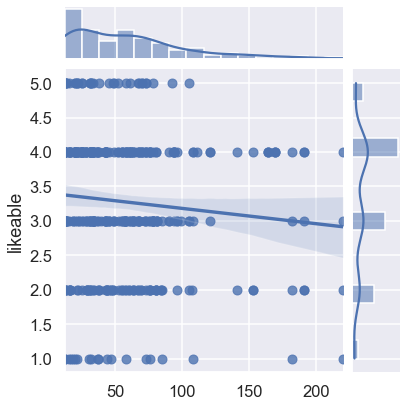

In [36]:
print("the_chain")
text_df=segue_text_df()
eval_df=segue_eval_df(load_answers())
eval_df=eval_df[eval_df.treatment=='the_chain']
df=text_df.set_index(['segue_idx','treatment']).join(eval_df.set_index(['segue_idx','treatment'])).reset_index()
_=sns.jointplot(x=[len(e) for e in df['text'].values], y=df['likeable'],kind="reg")

union


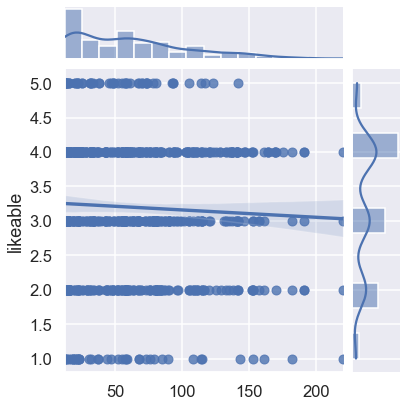

In [37]:
print("union")
text_df=segue_text_df()
eval_df=segue_eval_df(load_answers())
df=text_df.set_index(['segue_idx','treatment']).join(eval_df.set_index(['segue_idx','treatment'])).reset_index()
_=sns.jointplot(x=[len(e) for e in df['text'].values], y=df['likeable'],kind="reg")

On the x-axis, segue length in characters. </br>
Comments on the Union:
- Slightly negative slope, users tend to like more shorter texts;
- This effect was not caught when looking at the path length in graph. Maybe because short path length do not always imply short text;
- Possible take away here: do not worry about long to read segues, with increasing size of text, the likeability degrades only slightly

But probably those plots are just measuring user laziness...

# Confounding effects of familiarity
<a id="familiarity"></a>
[Go to top](#top)

We evaluate the influence of familiarity in metrics, with 95% bootstrap CIs.

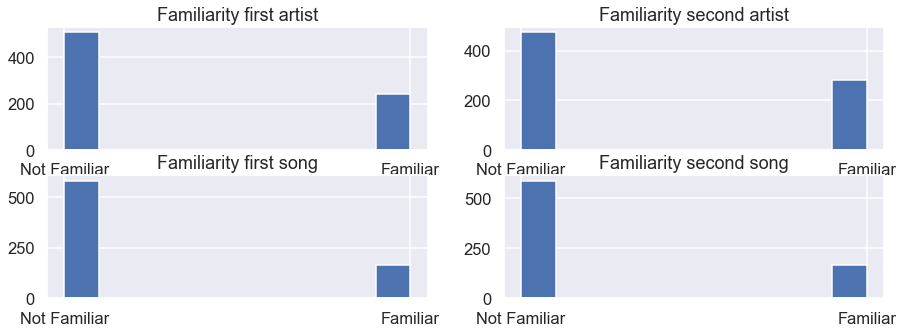

In [41]:
df_familarity=familiarity_df()
fig, (ax1, ax2)=plt.subplots(2,2, figsize=(15,5))
ax1[0].set_title("Familiarity first artist")
ax1[1].set_title("Familiarity second artist")
ax2[0].set_title("Familiarity first song")
ax2[1].set_title("Familiarity second song")
df_familarity.familiarity_first_artist.hist(ax=ax1[0], )
df_familarity.familiarity_second_artist.hist(ax=ax1[1])
df_familarity.familiarity_first_song.hist(ax=ax2[0])
_=df_familarity.familiarity_second_song.hist(ax=ax2[1])

In [42]:
df_eval=segue_eval_df(load_answers())
idx=['segue_idx','user_idx','treatment']
df=df_eval.set_index(idx).join(df_familarity.set_index(idx)).reset_index()

In [43]:
def step(df):
    return df[df.columns[3:-2]].groupby(['familiarity_first_artist', 'familiarity_second_artist']).mean()
print("dave")
add_bootstrap_ci(df[df.treatment=="dave"], step)

dave


likeable high_quality  \
familiarity_first_artist familiarity_second_artist                           
Familiar                 Familiar                   3.20±0.44    3.09±0.44   
                         Not Familiar               3.10±0.55    2.95±0.53   
Not Familiar             Familiar                   3.23±0.44    3.08±0.44   
                         Not Familiar               3.04±0.32    2.96±0.31   

                                                   understandable  \
familiarity_first_artist familiarity_second_artist                  
Familiar                 Familiar                       3.90±0.43   
                         Not Familiar                   3.78±0.53   
Not Familiar             Familiar                       3.76±0.46   
                         Not Familiar                   3.66±0.35   

                                                   sparked_interest  \
familiarity_first_artist familiarity_second_artist                    
Familiar                 Familiar                         3.00±0.47   
                         Not Familiar                     2.85±0.56   
Not Familiar             Familiar                         3.05±0.43   
                         Not Familiar                     2.78±0.33   

                                                        funny informative  \
familiarity_first_artist familiarity_second_artist                          
Familiar                 Familiar                   2.46±0.45   3.27±0.45   
                         Not Familiar               2.43±0.40   3.28±0.60   
Not Familiar             Familiar                   2.59±0.43   3.13±0.44   
                         Not Familiar               2.48±0.30   3.31±0.34   

                                                     creative well_written  
familiarity_first_artist familiarity_second_artist                          
Familiar                 Familiar                   3.34±0.45    3.31±0.46  
                         Not Familiar               3.30±0.45    3.26±0.52  
Not Familiar             Familiar                   3.31±0.34    3.31±0.39  
                         Not Familiar               3.27±0.33    3.31±0.30

In [44]:
def step(df):
    return df[list(df.columns[3:-4])+list(df.columns[-2:])].groupby(['familiarity_first_song', 'familiarity_second_song']).mean()
add_bootstrap_ci(df[df.treatment=="dave"], step)

likeable high_quality  \
familiarity_first_song familiarity_second_song                           
Familiar               Familiar                 3.37±0.65    3.05±0.65   
                       Not Familiar             3.10±0.60    2.95±0.53   
Not Familiar           Familiar                 3.23±0.70    2.97±0.66   
                       Not Familiar             3.07±0.26    3.02±0.26   

                                               understandable  \
familiarity_first_song familiarity_second_song                  
Familiar               Familiar                     3.95±0.65   
                       Not Familiar                 3.83±0.44   
Not Familiar           Familiar                     3.80±0.63   
                       Not Familiar                 3.69±0.30   

                                               sparked_interest      funny  \
familiarity_first_song familiarity_second_song                               
Familiar               Familiar                       3.35±0.61  2.43±0.67   
                       Not Familiar                   2.95±0.62  2.39±0.45   
Not Familiar           Familiar                       3.14±0.67  2.65±0.62   
                       Not Familiar                   2.77±0.26  2.49±0.23   

                                               informative   creative  \
familiarity_first_song familiarity_second_song                          
Familiar               Familiar                  3.21±0.62  3.40±0.71   
                       Not Familiar              3.39±0.64  3.33±0.51   
Not Familiar           Familiar                  3.18±0.72  3.39±0.47   
                       Not Familiar              3.25±0.28  3.26±0.24   

                                               well_written  
familiarity_first_song familiarity_second_song               
Familiar               Familiar                   3.45±0.71  
                       Not Familiar               3.28±0.57  
Not Familiar           Familiar                   3.33±0.49  
                       Not Familiar               3.28±0.26

In [45]:
def step(df):
    return df[df.columns[3:-2]].groupby(['familiarity_first_artist', 'familiarity_second_artist']).mean()
print("the chain")
add_bootstrap_ci(df[df.treatment=="the_chain"], step)

the chain


likeable high_quality  \
familiarity_first_artist familiarity_second_artist                           
Familiar                 Familiar                   3.41±0.60    3.22±0.68   
                         Not Familiar               3.37±0.48    3.15±0.48   
Not Familiar             Familiar                   3.24±0.50    3.11±0.49   
                         Not Familiar               3.24±0.29    3.17±0.29   

                                                   understandable  \
familiarity_first_artist familiarity_second_artist                  
Familiar                 Familiar                       3.85±0.65   
                         Not Familiar                   3.94±0.42   
Not Familiar             Familiar                       3.80±0.53   
                         Not Familiar                   3.69±0.35   

                                                   sparked_interest  \
familiarity_first_artist familiarity_second_artist                    
Familiar                 Familiar                         3.20±0.67   
                         Not Familiar                     3.05±0.52   
Not Familiar             Familiar                         3.09±0.51   
                         Not Familiar                     2.93±0.31   

                                                        funny informative  \
familiarity_first_artist familiarity_second_artist                          
Familiar                 Familiar                   2.89±0.56   3.23±0.61   
                         Not Familiar               2.99±0.49   3.19±0.49   
Not Familiar             Familiar                   2.80±0.47   3.03±0.46   
                         Not Familiar               2.74±0.28   2.95±0.29   

                                                     creative well_written  
familiarity_first_artist familiarity_second_artist                          
Familiar                 Familiar                   3.73±0.46    3.57±0.58  
                         Not Familiar               3.57±0.45    3.38±0.48  
Not Familiar             Familiar                   3.65±0.47    3.34±0.46  
                         Not Familiar               3.51±0.29    3.25±0.29

In [46]:
def step(df):
    return df[list(df.columns[3:-4])+list(df.columns[-2:])].groupby(['familiarity_first_song', 'familiarity_second_song']).mean()
add_bootstrap_ci(df[df.treatment=="the_chain"], step)

likeable high_quality  \
familiarity_first_song familiarity_second_song                           
Familiar               Familiar                 3.61±0.62    3.31±0.79   
                       Not Familiar             3.32±0.56    3.14±0.59   
Not Familiar           Familiar                 3.48±0.58    3.42±0.59   
                       Not Familiar             3.19±0.26    3.09±0.26   

                                               understandable  \
familiarity_first_song familiarity_second_song                  
Familiar               Familiar                     3.88±0.67   
                       Not Familiar                 3.90±0.54   
Not Familiar           Familiar                     4.00±0.54   
                       Not Familiar                 3.70±0.29   

                                               sparked_interest      funny  \
familiarity_first_song familiarity_second_song                               
Familiar               Familiar                       3.46±0.65  2.94±0.58   
                       Not Familiar                   3.14±0.60  2.75±0.59   
Not Familiar           Familiar                       3.46±0.64  2.91±0.60   
                       Not Familiar                   2.84±0.27  2.79±0.25   

                                               informative   creative  \
familiarity_first_song familiarity_second_song                          
Familiar               Familiar                  3.37±0.65  3.64±0.63   
                       Not Familiar              3.25±0.58  3.59±0.52   
Not Familiar           Familiar                  3.15±0.59  3.84±0.53   
                       Not Familiar              2.93±0.27  3.49±0.25   

                                               well_written  
familiarity_first_song familiarity_second_song               
Familiar               Familiar                   3.61±0.71  
                       Not Familiar               3.45±0.60  
Not Familiar           Familiar                   3.65±0.45  
                       Not Familiar               3.20±0.26

In [47]:
def step(df):
    return df[df.columns[3:-2]].groupby(['familiarity_first_artist', 'familiarity_second_artist']).mean()
print("union")
add_bootstrap_ci(df, step)

union


likeable high_quality  \
familiarity_first_artist familiarity_second_artist                           
Familiar                 Familiar                   3.28±0.38    3.13±0.38   
                         Not Familiar               3.25±0.34    3.06±0.36   
Not Familiar             Familiar                   3.24±0.34    3.10±0.33   
                         Not Familiar               3.14±0.21    3.07±0.22   

                                                   understandable  \
familiarity_first_artist familiarity_second_artist                  
Familiar                 Familiar                       3.88±0.39   
                         Not Familiar                   3.87±0.34   
Not Familiar             Familiar                       3.78±0.34   
                         Not Familiar                   3.67±0.25   

                                                   sparked_interest  \
familiarity_first_artist familiarity_second_artist                    
Familiar                 Familiar                         3.08±0.38   
                         Not Familiar                     2.96±0.40   
Not Familiar             Familiar                         3.06±0.35   
                         Not Familiar                     2.86±0.24   

                                                        funny informative  \
familiarity_first_artist familiarity_second_artist                          
Familiar                 Familiar                   2.64±0.35   3.25±0.39   
                         Not Familiar               2.75±0.36   3.23±0.38   
Not Familiar             Familiar                   2.68±0.31   3.09±0.35   
                         Not Familiar               2.62±0.20   3.11±0.23   

                                                     creative well_written  
familiarity_first_artist familiarity_second_artist                          
Familiar                 Familiar                   3.50±0.33    3.41±0.38  
                         Not Familiar               3.45±0.31    3.33±0.35  
Not Familiar             Familiar                   3.45±0.31    3.32±0.31  
                         Not Familiar               3.39±0.22    3.28±0.22

In [48]:
def step(df):
    return df[list(df.columns[3:-4])+list(df.columns[-2:])].groupby(['familiarity_first_song', 'familiarity_second_song']).mean()
add_bootstrap_ci(df, step)

likeable high_quality  \
familiarity_first_song familiarity_second_song                           
Familiar               Familiar                 3.50±0.45    3.19±0.50   
                       Not Familiar             3.22±0.41    3.05±0.37   
Not Familiar           Familiar                 3.35±0.46    3.19±0.46   
                       Not Familiar             3.13±0.18    3.05±0.19   

                                               understandable  \
familiarity_first_song familiarity_second_song                  
Familiar               Familiar                     3.91±0.46   
                       Not Familiar                 3.86±0.35   
Not Familiar           Familiar                     3.90±0.41   
                       Not Familiar                 3.70±0.21   

                                               sparked_interest      funny  \
familiarity_first_song familiarity_second_song                               
Familiar               Familiar                       3.41±0.44  2.68±0.48   
                       Not Familiar                   3.05±0.42  2.58±0.39   
Not Familiar           Familiar                       3.30±0.46  2.79±0.43   
                       Not Familiar                   2.80±0.21  2.64±0.18   

                                               informative   creative  \
familiarity_first_song familiarity_second_song                          
Familiar               Familiar                  3.29±0.45  3.52±0.46   
                       Not Familiar              3.32±0.41  3.46±0.35   
Not Familiar           Familiar                  3.16±0.46  3.62±0.37   
                       Not Familiar              3.09±0.20  3.38±0.18   

                                               well_written  
familiarity_first_song familiarity_second_song               
Familiar               Familiar                   3.53±0.51  
                       Not Familiar               3.37±0.41  
Not Familiar           Familiar                   3.49±0.35  
                       Not Familiar               3.24±0.18

Comments on Dave and The Chain separately:
- In The Chain the metrics tend to increase more when there is familiarity than in Dave; However there is pretty high uncertainty, not sure that this holds statistically. We drop the tables between treatments, and just say they behave in the same way, and comment just the union.

Comments on the Union:
- Scores tend to rise with the familiarity of the user with the entities involved;
- Familiarity with songs makes metrics rise more than familiarity with artists. Other than this, same behaviour, only the magnitude changes. We might show just familiarity with songs;

General comments:
- It does not make sense to partition further (on user category and segue category) because we have already a lot of uncertainty, very few people are familiar with songs and artists.